In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))
    
    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size
    
model_file_name = "ms2deepscore_model.pt"
neg_val_spectra_file_name = "neg_validation_spectra.mgf"
pos_val_spectra_file_name = "pos_validation_spectra.mgf"

download_file("https://zenodo.org/records/13897744/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/13897744/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://zenodo.org/records/13934470/files/negative_validation_spectra.mgf?download=1", neg_val_spectra_file_name)
download_file("https://zenodo.org/records/13934470/files/positive_validation_spectra.mgf?download=1", pos_val_spectra_file_name)

In [4]:
from matchms.importing import load_from_mgf
from tqdm import tqdm
import os 


pos_val = list(tqdm(load_from_mgf(pos_val_spectra_file_name)))
neg_val = list(tqdm(load_from_mgf(neg_val_spectra_file_name)))

25412it [00:40, 628.47it/s] 
7551it [00:19, 385.10it/s] 


In [5]:
from ms2deepscore.models.load_model import load_model
from ms2deepscore import MS2DeepScore
model = MS2DeepScore(load_model(model_file_name))

c:\users\jonge094\pycharmprojects\ms2deepscore\ms2deepscore\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(f

The model version (2.0.0) does not match the version of MS2Deepscore (2.1.0), consider downloading a new model or changing the MS2Deepscore version


In [26]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from ms2deepscore.benchmarking.calculate_scores_for_validation import calculate_tanimoto_scores_unique_inchikey
from ms2deepscore.vector_operations import cosine_similarity_matrix

def convert_predictions_matrix_to_average_per_inchikey(predictions_df, symmetric = True):
    # remove predicitons between the same spectrum
    if symmetric:
        np.fill_diagonal(predictions_df.values, np.nan)
    # get the mean prediction per inchikey
    df_grouped = predictions_df.groupby(predictions_df.index).mean()  # Grouping rows by index and averaging across columns
    df_grouped_columns = df_grouped.groupby(lambda x: x, axis=1).mean()  # Grouping columns with duplicate names
    return df_grouped_columns

def select_pairs_per_bin(tanimoto_scores, nr_of_bins):
    bins = np.linspace(0, 1, nr_of_bins)
    digitized = np.digitize(tanimoto_scores, bins) - 1
    pairs_per_bin = []
    for bin in tqdm(range(nr_of_bins), desc="Selecting available inchikey pairs per bin"):
        pairs = []
        pairs_in_bin = np.where(digitized == bin)
        for i in range(len(pairs_in_bin[0])):
            inchikey_idx_1 = pairs_in_bin[0][i]
            inchikey_idx_2 = pairs_in_bin[1][i]
            pairs.append((tanimoto_scores.index[inchikey_idx_1],tanimoto_scores.columns[inchikey_idx_2]))
        pairs_per_bin.append(pairs)
    return pairs_per_bin

def add_predicition_and_score_to_pairs(pairs_per_bin, predictions_per_inchikey, tanimoto_df):
    score_pairs_per_bin = []
    for pairs_in_bin in tqdm(pairs_per_bin, desc="Get score and prediction per pair"):
        scores_in_bin = []
        for inchikey_1, inchikey_2 in pairs_in_bin:
            prediction = predictions_per_inchikey[inchikey_2][inchikey_1]
            # don't include pairs where the prediciton is Nan (this is the case when only a pair against itself is available)
            if not np.isnan(prediction):
                tanimoto = tanimoto_df[inchikey_2][inchikey_1]
                scores_in_bin.append((tanimoto, prediction))
        score_pairs_per_bin.append(scores_in_bin)
    return score_pairs_per_bin

class ReshuffleSampler:
    def __init__(self, values):
        self.original_values = values
        self.current_values = []
        self.shuffle()

    def shuffle(self):
        """Shuffle the list and reset the current values."""
        self.current_values = self.original_values.copy()
        random.shuffle(self.current_values)

    def sample(self):
        """Sample a value, reshuffle if list is exhausted."""
        if not self.current_values:
            self.shuffle()  # Reshuffle when the list is exhausted
        return self.current_values.pop()  # Pop a value from the list

def sample_pairs_per_bin_equally(score_pairs_per_bin, nr_of_pairs_per_bin):
    selected_pairs = []
    for pairs_in_bin in tqdm(score_pairs_per_bin, desc="Sample pairs per bin"):
        sampler = ReshuffleSampler(pairs_in_bin)

        for i in range(nr_of_pairs_per_bin):
            selected_pairs.append(sampler.sample())
    return selected_pairs

def create_embedding_matrix_symmetric(model, spectra):
    print("Calculating embeddings") 
    embeddings = model.get_embedding_array(spectra)
    print("Calculating similarity between embeddings")
    predictions = cosine_similarity_matrix(embeddings, embeddings)
    # Select the inchikeys per spectrum
    inchikeys = []
    for spectrum in spectra:
        inchikeys.append(spectrum.get("inchikey")[:14])
    # create dataframe with inchikeys as indexes
    predictions_df = pd.DataFrame(predictions, index=inchikeys, columns = inchikeys)
    return predictions_df


def create_embedding_matrix_not_symmetric(model, spectra, spectra_2):
    print("Calculating embeddings") 
    embeddings1 = model.get_embedding_array(spectra)
    embeddings2 = model.get_embedding_array(spectra_2)
    print("Calculating similarity between embeddings")

    predictions = cosine_similarity_matrix(embeddings1, embeddings2)
    # Select the inchikeys per spectrum
    inchikeys1 = [spectrum.get("inchikey")[:14] for spectrum in spectra]
    inchikeys2 = [spectrum.get("inchikey")[:14] for spectrum in spectra_2]

    # create dataframe with inchikeys as indexes
    predictions_df = pd.DataFrame(predictions, index=inchikeys1, columns = inchikeys2)
    return predictions_df


def get_heatmap_data_wrapper(model, spectra_1, spectra_2, nr_of_bins, nr_of_pairs_per_bin):
    symmetric = False
    if spectra_2 is None:
        spectra_2 = spectra_1
        symmetric = True
    if symmetric: 
        predictions_df = create_embedding_matrix_symmetric(model, spectra_1)
    else:
        predictions_df = create_embedding_matrix_not_symmetric(model, spectra_1, spectra_2)
    predictions_per_inchikey = convert_predictions_matrix_to_average_per_inchikey(predictions_df, symmetric=symmetric)
    tanimoto_scores = calculate_tanimoto_scores_unique_inchikey(spectra_1, spectra_2)
    
    pairs_per_bin = select_pairs_per_bin(tanimoto_scores, nr_of_bins)
    score_pairs_per_bin = add_predicition_and_score_to_pairs(pairs_per_bin, predictions_per_inchikey, tanimoto_scores)
    selected_pairs = sample_pairs_per_bin_equally(score_pairs_per_bin, nr_of_pairs_per_bin)
    heatmap, yedges = get_heatmap_data(selected_pairs, nr_of_bins)
    return heatmap, yedges

def get_heatmap_data(selected_pairs, nr_of_bins):
    tanimoto_scores = [scores[0] for scores in selected_pairs]
    predicted_scores = [scores[1] for scores in selected_pairs]
    
    heatmap, xedged, yedges = np.histogram2d(tanimoto_scores, predicted_scores, bins=nr_of_bins, range=[[0, 1], None])
    return heatmap, yedges

def plot_3_heatmaps(pos_pos_heatmap, neg_neg_heatmap, pos_neg_heatmap):
    
    maximum_heatmap_intensity = max(pos_pos_heatmap[0].max(), neg_neg_heatmap[0].max(), pos_neg_heatmap[0].max())
    minimum_y_axis = min(pos_pos_heatmap[1].min(), neg_neg_heatmap[1].min(), pos_neg_heatmap[1].min())

    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(neg_neg_heatmap[0].T, origin='lower', interpolation='nearest', extent=[0, 1, minimum_y_axis, 1],cmap="inferno", 
                   vmax = maximum_heatmap_intensity)
    axes[0].set_xlabel("True chemical similarity")
    axes[0].set_ylabel("Predicted chemical similarity")
    axes[0].set_title("Negative vs negative")
    
    axes[1].imshow(pos_pos_heatmap[0].T, origin='lower', interpolation='nearest', extent=[0, 1, minimum_y_axis, 1],cmap="inferno", 
                   vmax = maximum_heatmap_intensity)
    axes[1].set_xlabel("True chemical similarity")
    axes[1].set_ylabel("Predicted chemical similarity")
    axes[1].set_title("Positive vs positive")
    
    im2 = axes[2].imshow(pos_neg_heatmap[0].T, origin='lower', interpolation='nearest', extent=[0, 1, minimum_y_axis, 1],cmap="inferno", 
                   vmax = maximum_heatmap_intensity)
    axes[2].set_xlabel("True chemical similarity")
    axes[2].set_ylabel("Predicted chemical similarity")
    axes[2].set_title("Positive vs negative")
    
    cbar = fig.colorbar(im2, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Density')  # Label for the colorbar
    plt.show()

def create_3_heatmap_plots(model, pos_spectra, neg_spectra, nr_of_bins, nr_of_pairs_per_bin):
    print("creating heatmap for pos vs neg")
    pos_neg_heatmap = get_heatmap_data_wrapper(model, pos_spectra, neg_spectra, nr_of_bins, nr_of_pairs_per_bin)
    print("creating heatmap for pos vs pos")
    pos_pos_heatmap = get_heatmap_data_wrapper(model, pos_spectra, None, nr_of_bins, nr_of_pairs_per_bin)
    print("creating heatmap for neg vs neg")
    neg_neg_heatmap = get_heatmap_data_wrapper(model, neg_spectra, None, nr_of_bins, nr_of_pairs_per_bin)
    plot_3_heatmaps(pos_pos_heatmap, neg_neg_heatmap, pos_neg_heatmap)



creating heatmap for pos vs neg
Calculating embeddings


25412it [03:16, 129.01it/s]
7551it [00:59, 127.06it/s]


Calculating similarity between embeddings


C:\Users\jonge094\AppData\Local\Temp\ipykernel_17096\1978963868.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_grouped_columns = df_grouped.groupby(lambda x: x, axis=1).mean()  # Grouping columns with duplicate names
Calculating fingerprints: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 298.48it/s]


Calculating tanimoto scores


Sample pairs per bin: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.63it/s]


creating heatmap for pos vs pos
Calculating embeddings


25412it [03:12, 132.00it/s]


Calculating similarity between embeddings


C:\Users\jonge094\AppData\Local\Temp\ipykernel_17096\1978963868.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_grouped_columns = df_grouped.groupby(lambda x: x, axis=1).mean()  # Grouping columns with duplicate names
Calculating fingerprints: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:06<00:00, 272.26it/s]


Calculating tanimoto scores


Sample pairs per bin: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.71it/s]


creating heatmap for neg vs neg
Calculating embeddings


7551it [01:00, 125.82it/s]


Calculating similarity between embeddings


C:\Users\jonge094\AppData\Local\Temp\ipykernel_17096\1978963868.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_grouped_columns = df_grouped.groupby(lambda x: x, axis=1).mean()  # Grouping columns with duplicate names
Calculating fingerprints: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:04<00:00, 229.98it/s]


Calculating tanimoto scores


Sample pairs per bin: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 51.40it/s]


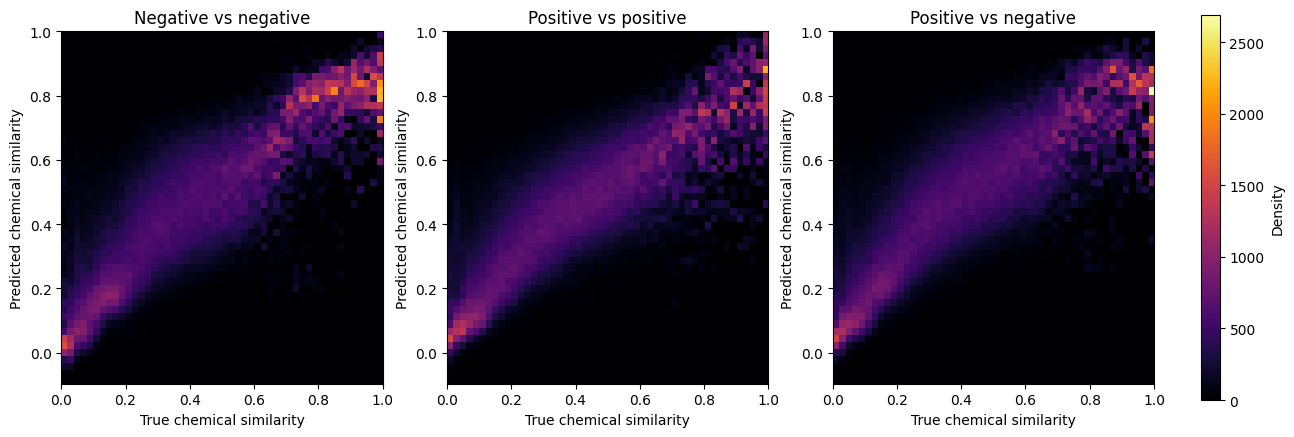

In [28]:
create_3_heatmap_plots(model, pos_val, neg_val, 50, 10000)

# Plot prediction distribution per bin:
The prediction is plotted per bin with actual scores.

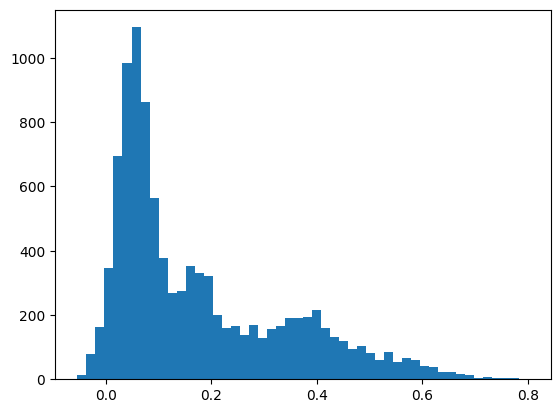

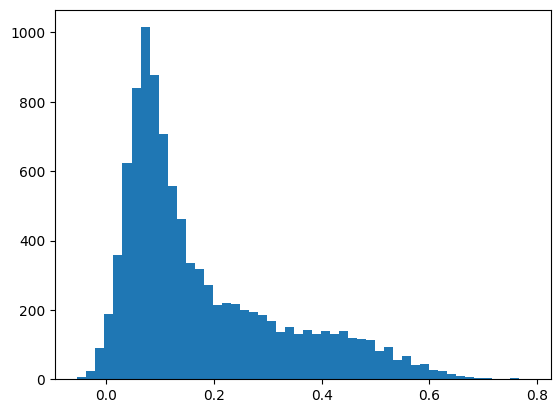

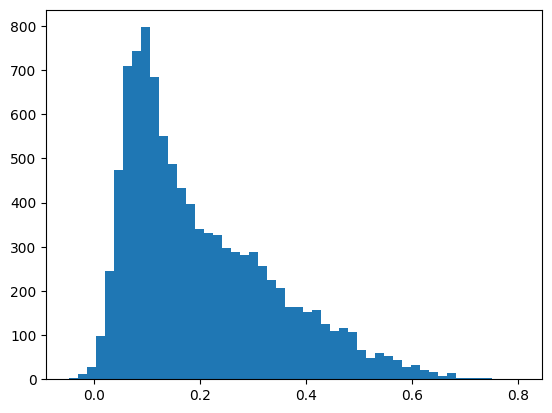

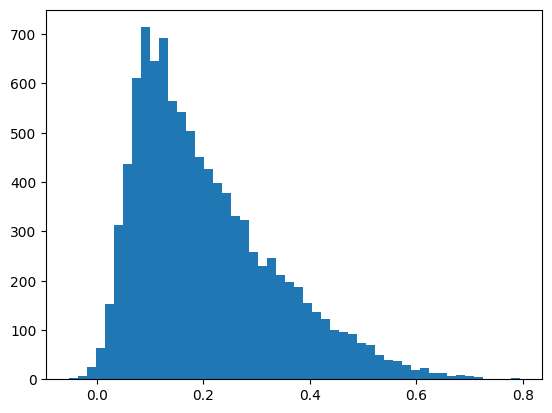

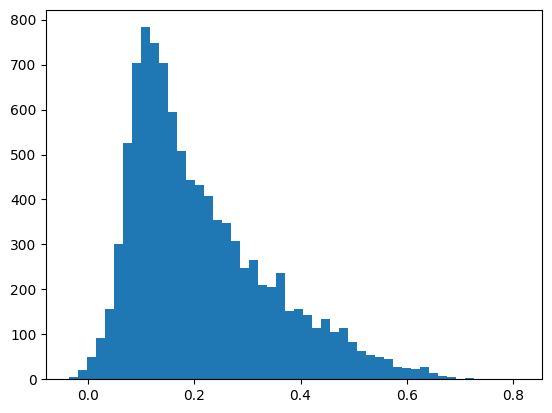

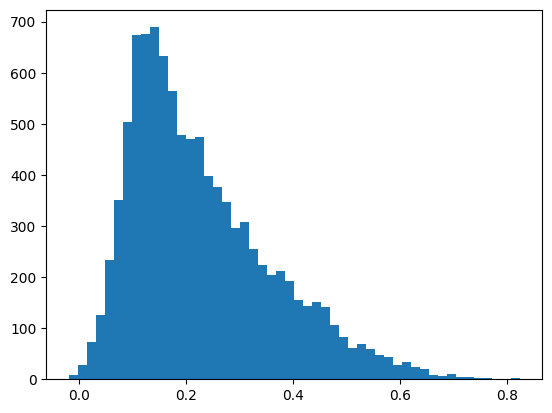

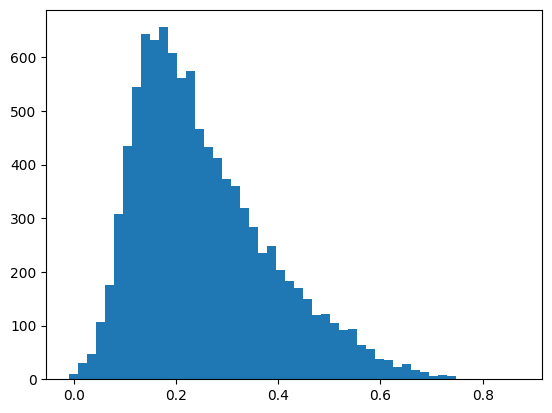

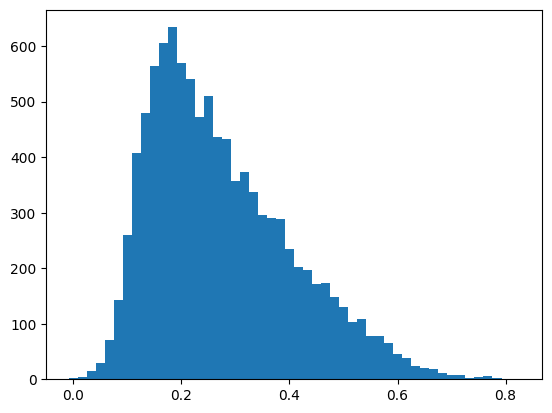

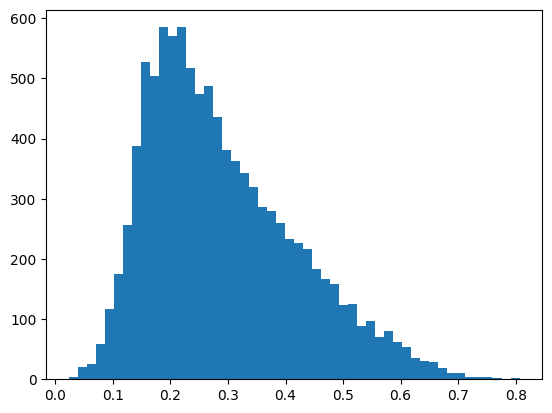

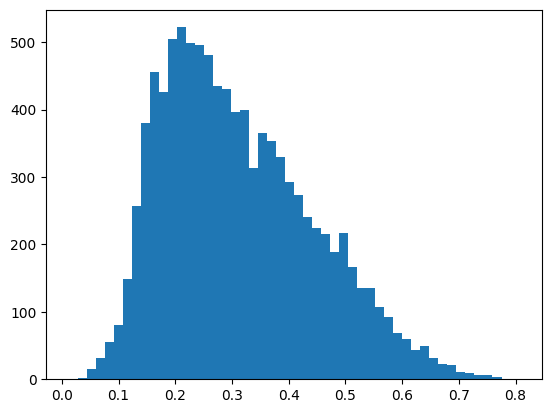

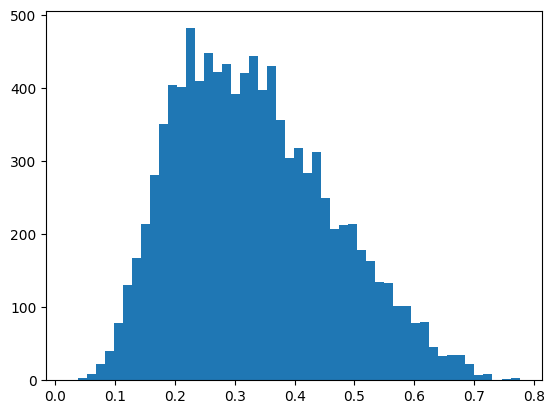

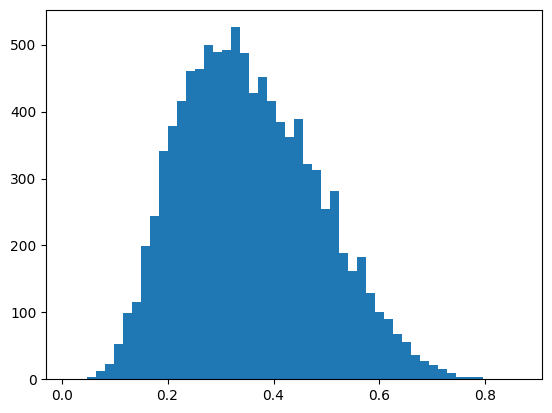

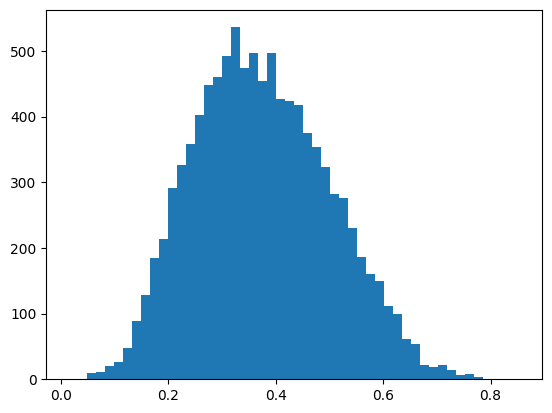

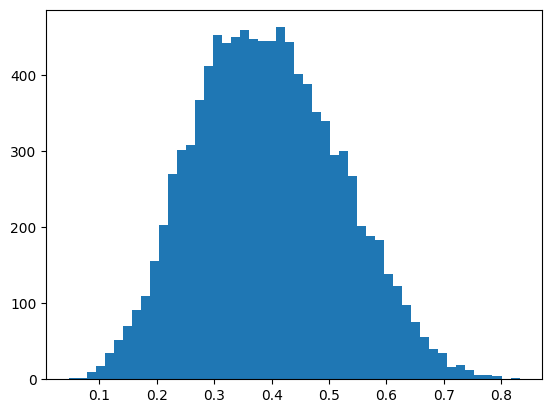

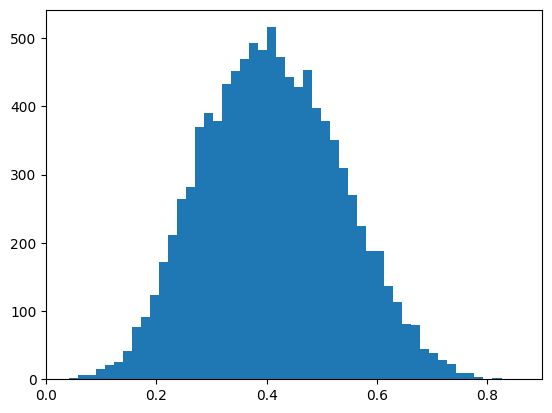

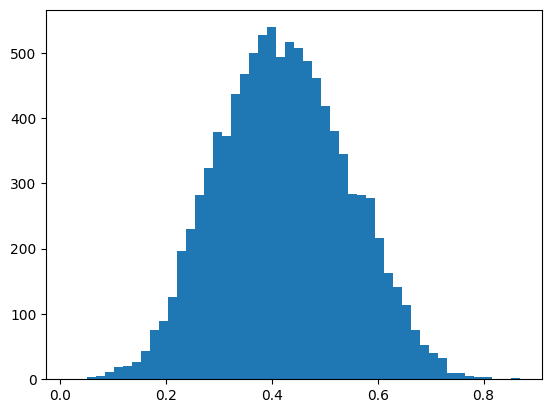

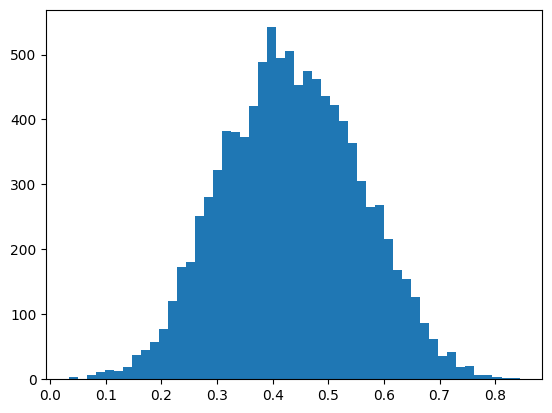

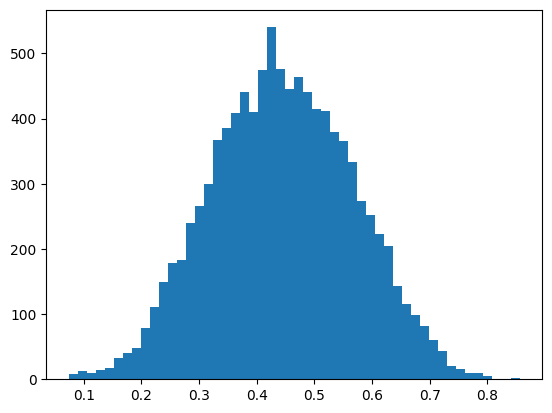

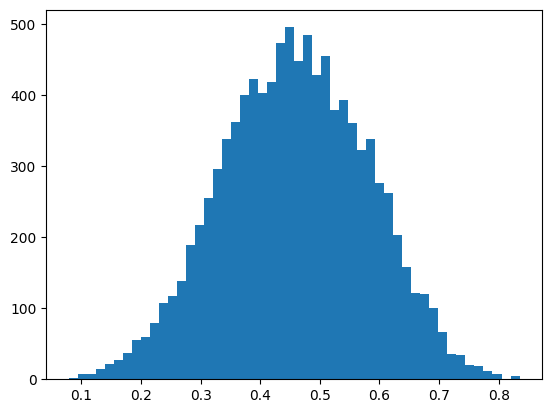

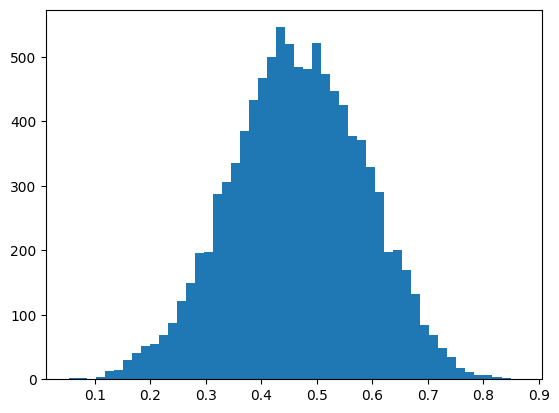

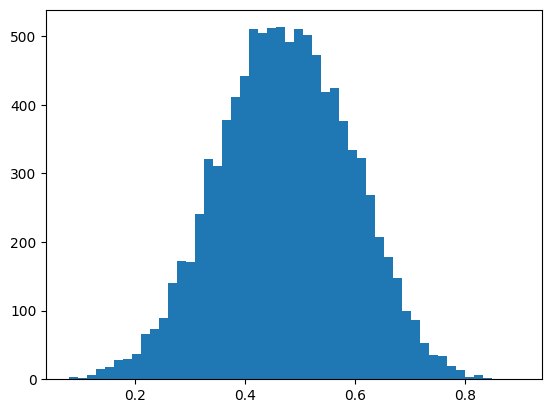

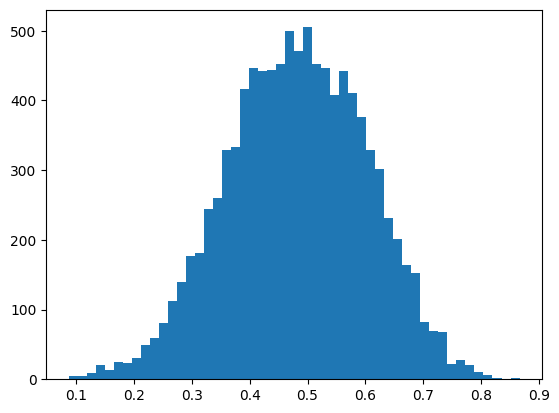

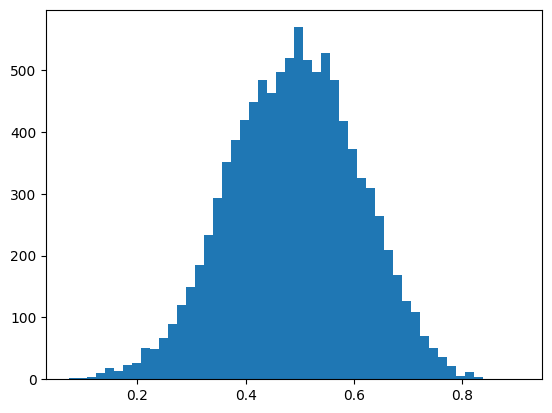

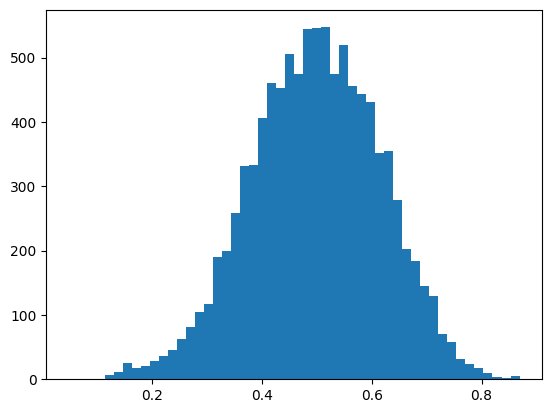

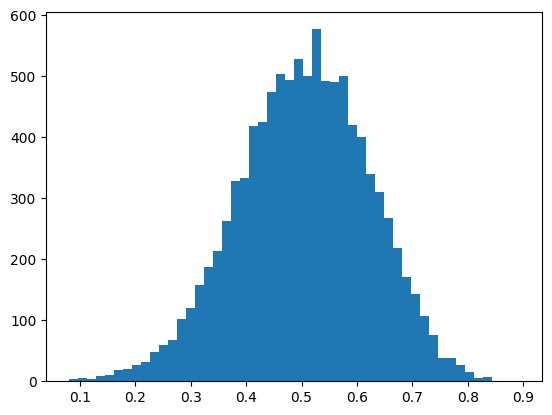

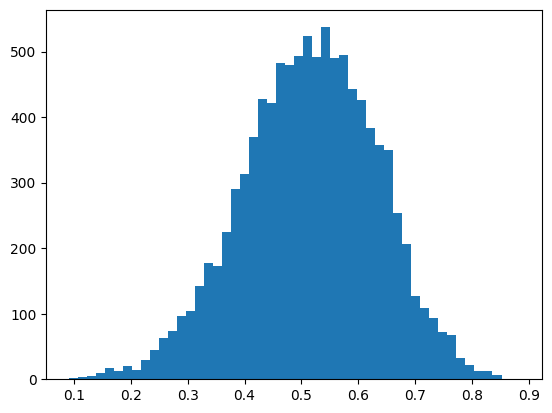

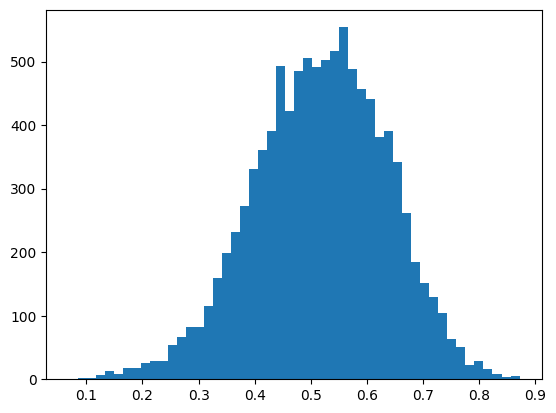

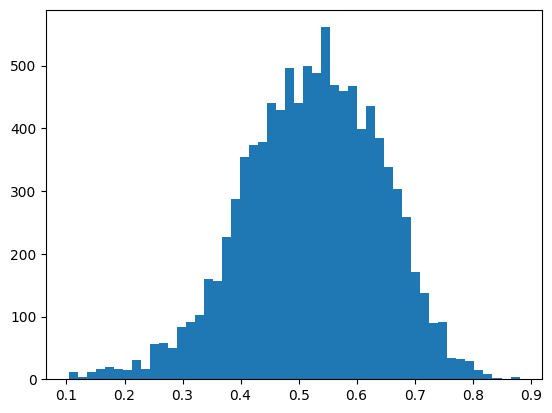

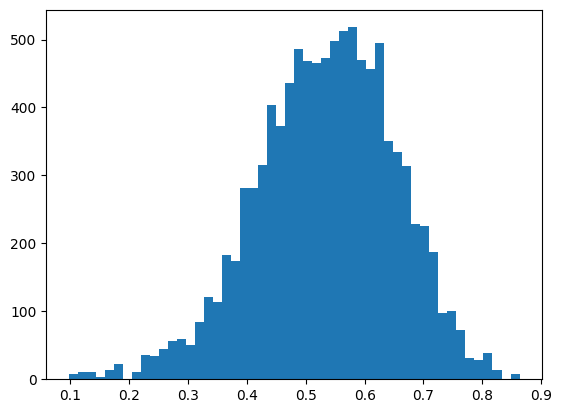

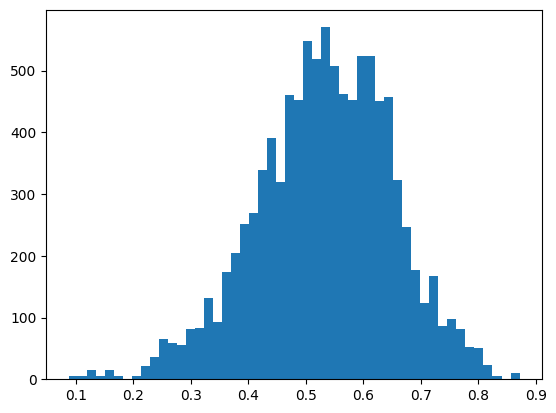

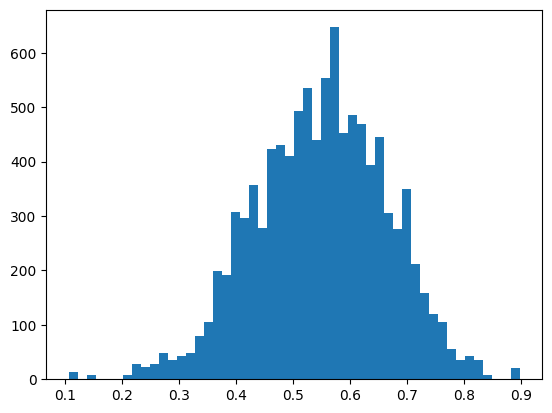

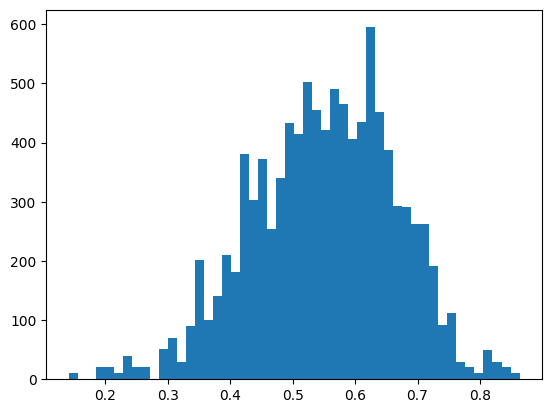

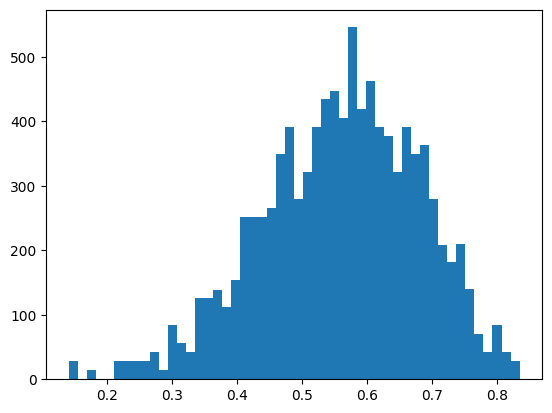

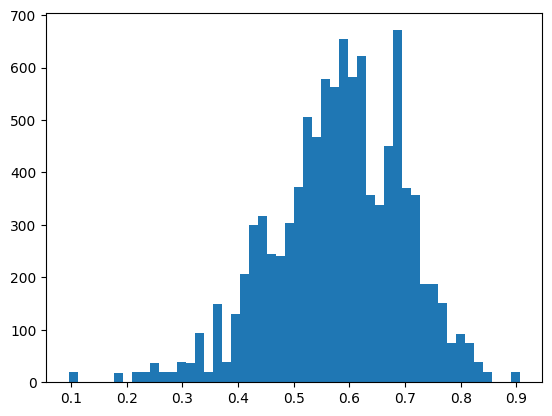

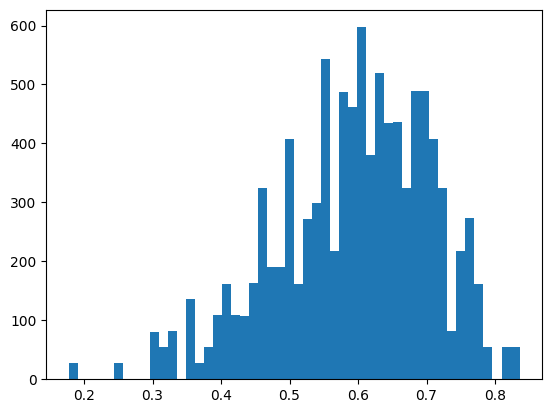

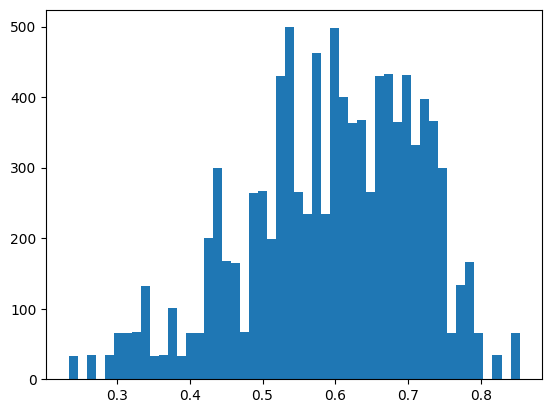

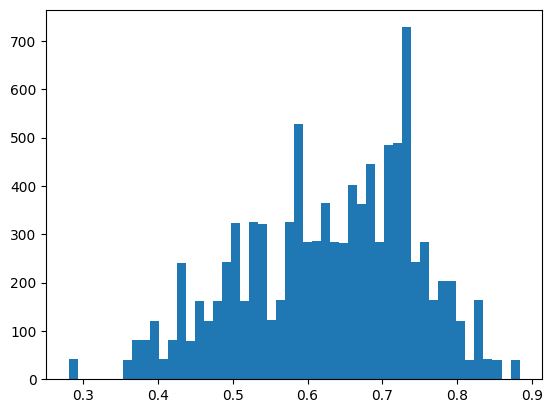

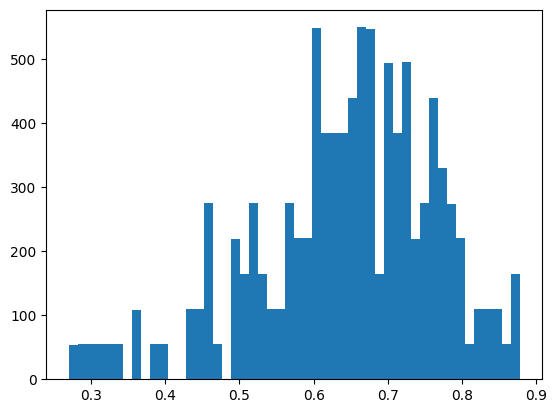

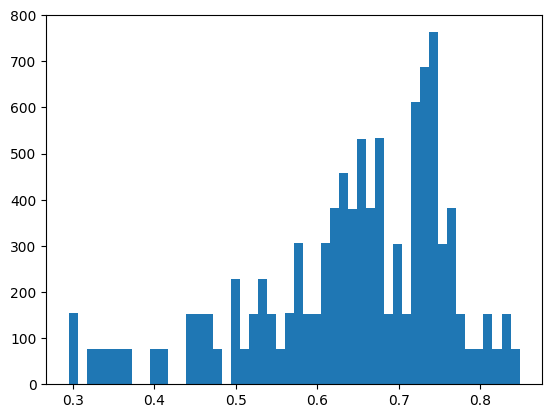

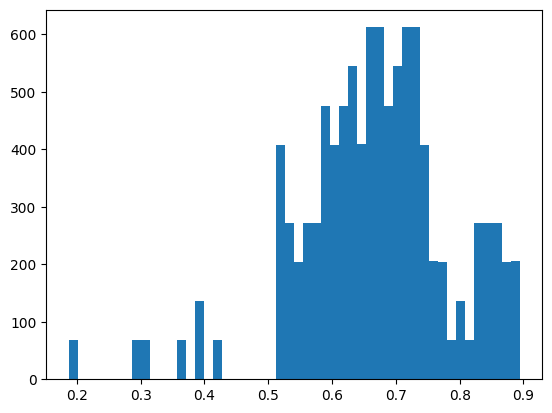

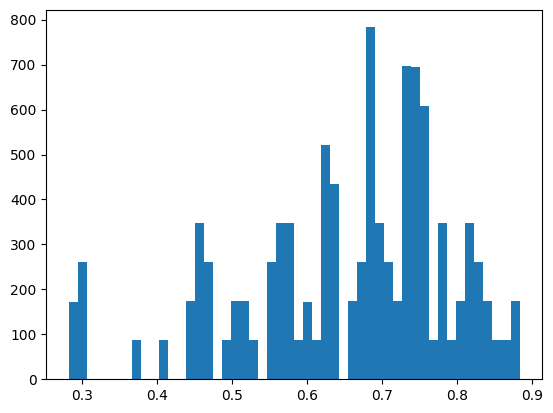

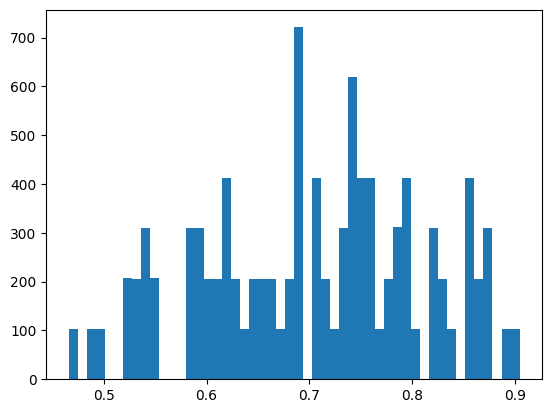

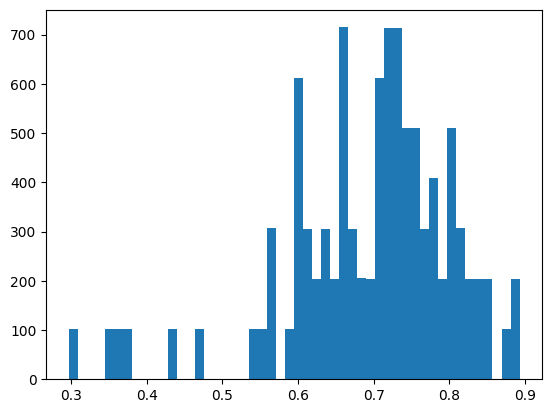

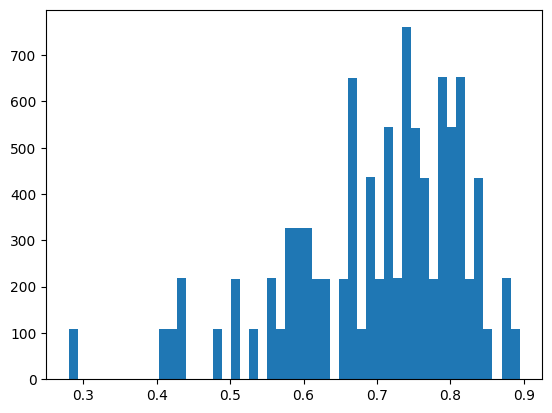

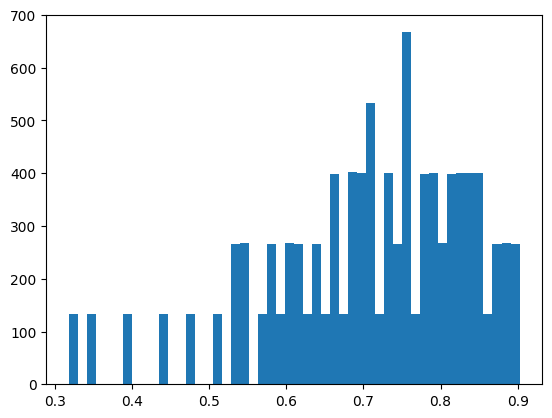

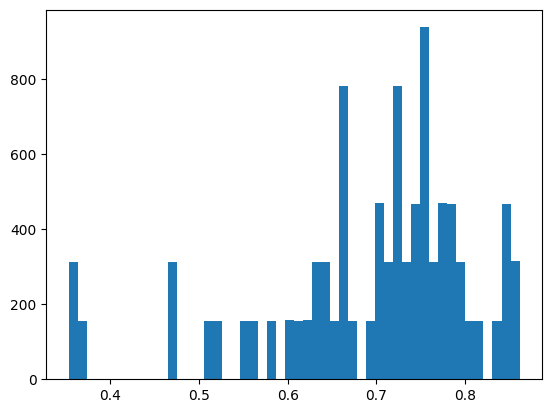

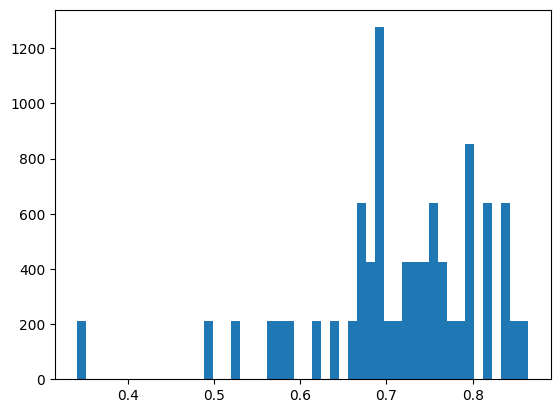

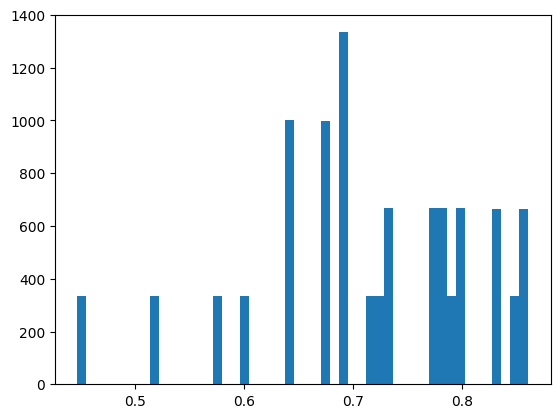

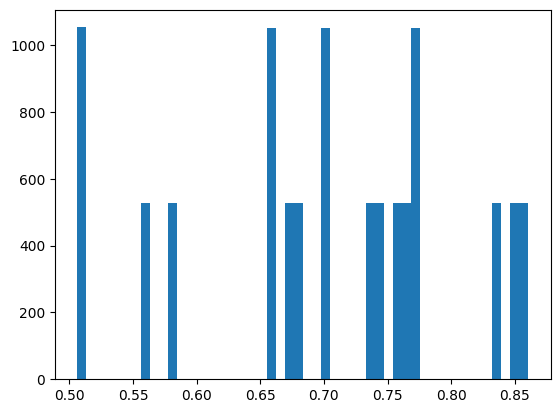

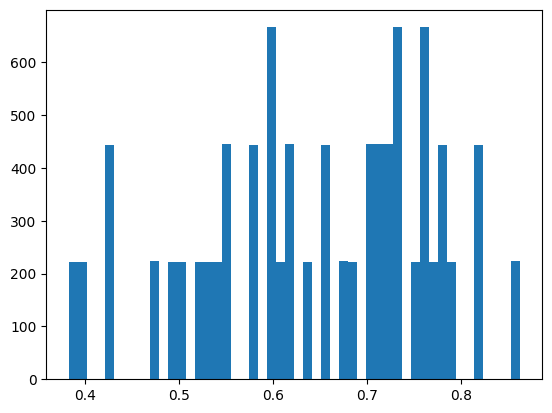

In [92]:
predictions_df = create_embedding_matrix_not_symmetric(model, pos_val, pos_val)
predictions_per_inchikey = convert_predictions_matrix_to_average_per_inchikey(predictions_df, symmetric=True)
tanimoto_scores = calculate_tanimoto_scores_unique_inchikey(pos_val, pos_val)

pairs_per_bin = select_pairs_per_bin(tanimoto_scores, nr_of_bins)
score_pairs_per_bin = add_predicition_and_score_to_pairs(pairs_per_bin, predictions_per_inchikey, tanimoto_scores)
selected_pairs = sample_pairs_per_bin_equally(score_pairs_per_bin, nr_of_pairs_per_bin)

for i in range(50):
    sorted_scores = sorted([pair[1] for pair in selected_pairs[10000*i:10000*i + 10000]])
    sorted_scores.reverse()
    plt.hist(sorted_scores, bins = 50)
    plt.show()

# Plot average per bin
Below the code for plotting an average per bin plot

In [32]:
def get_score_pairs_per_bin_wrapper(model, spectra_1, spectra_2, nr_of_bins):
    symmetric = False
    if spectra_2 is None:
        spectra_2 = spectra_1
        symmetric = True
    if symmetric: 
        predictions_df = create_embedding_matrix_symmetric(model, spectra_1)
    else:
        predictions_df = create_embedding_matrix_not_symmetric(model, spectra_1, spectra_2)
    predictions_per_inchikey = convert_predictions_matrix_to_average_per_inchikey(predictions_df, symmetric=symmetric)
    tanimoto_scores = calculate_tanimoto_scores_unique_inchikey(spectra_1, spectra_2)
    
    pairs_per_bin = select_pairs_per_bin(tanimoto_scores, nr_of_bins)
    score_pairs_per_bin = add_predicition_and_score_to_pairs(pairs_per_bin, predictions_per_inchikey, tanimoto_scores)
    return score_pairs_per_bin


def plot_average_per_bin(score_pairs_per_bin, label = ""):
    avg_tanimoto_scores = []
    avg_predictions = []

    for score_pairs in score_pairs_per_bin:
        tanimoto_scores = [score[0] for score in score_pairs]
        predictions = [score[1] for score in score_pairs]
        avg_tanimoto_scores.append(sum(tanimoto_scores)/len(tanimoto_scores))
        avg_prediction = sum(predictions)/len(predictions)
        avg_predictions.append(avg_prediction)
    plt.plot(avg_tanimoto_scores, avg_predictions, label=label)

    plt.xlim(0,1)
    plt.ylim(0,1)

def create_3_average_per_bin_plots(model, pos_spectra, neg_spectra, nr_of_bins):
    print("creating heatmap for pos vs pos")
    pos_pos_score_pairs = get_score_pairs_per_bin_wrapper(model, pos_spectra, None, nr_of_bins)
    print("creating heatmap for neg vs neg")
    neg_neg_score_pairs = get_score_pairs_per_bin_wrapper(model, neg_spectra, None, nr_of_bins)
    print("creating heatmap for pos vs neg")
    pos_neg_score_pairs = get_score_pairs_per_bin_wrapper(model, pos_spectra, neg_spectra, nr_of_bins)
    plot_average_per_bin(pos_pos_score_pairs, "Positive vs Positive")
    plot_average_per_bin(neg_neg_score_pairs, "Negative vs Negative")
    plot_average_per_bin(pos_neg_score_pairs, "Positive vs Negative")
    plt.legend()
    

creating heatmap for pos vs pos
Calculating embeddings


25412it [39:44, 10.66it/s] 


Calculating similarity between embeddings


C:\Users\jonge094\AppData\Local\Temp\ipykernel_17096\1978963868.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_grouped_columns = df_grouped.groupby(lambda x: x, axis=1).mean()  # Grouping columns with duplicate names
Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:16<00:00, 111.04it/s]


Calculating tanimoto scores


Get score and prediction per pair: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:20<00:00,  2.80s/it]


creating heatmap for neg vs neg
Calculating embeddings


7551it [01:39, 75.99it/s]


Calculating similarity between embeddings


C:\Users\jonge094\AppData\Local\Temp\ipykernel_17096\1978963868.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_grouped_columns = df_grouped.groupby(lambda x: x, axis=1).mean()  # Grouping columns with duplicate names
Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:08<00:00, 109.61it/s]


Calculating tanimoto scores


Get score and prediction per pair: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.45it/s]


creating heatmap for pos vs neg
Calculating embeddings


25412it [05:32, 76.41it/s]
7551it [01:40, 75.08it/s]


Calculating similarity between embeddings


C:\Users\jonge094\AppData\Local\Temp\ipykernel_17096\1978963868.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df_grouped_columns = df_grouped.groupby(lambda x: x, axis=1).mean()  # Grouping columns with duplicate names
Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:08<00:00, 106.00it/s]


Calculating tanimoto scores


Get score and prediction per pair: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.37s/it]


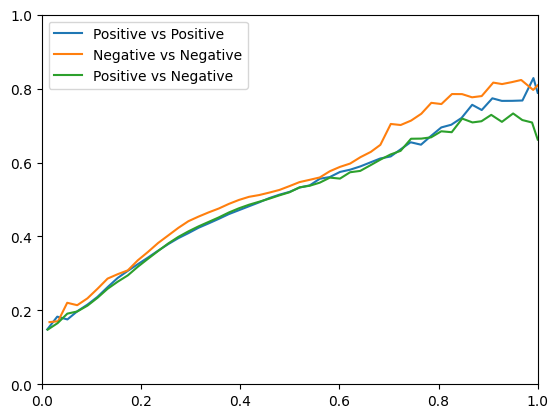

In [33]:
create_3_average_per_bin_plots(model, pos_val, neg_val, 50)